## **Multivariate Outlier Detection in Geochemical Datasets**
Author: Tyler Howe  
Last Updated: February 2025  

<br />
This notebook explores and compares three different methods of multivariate outlier detection in geochemical datasets, with a focus on applications in mineral exploration.  
<br />For this example, we use geochemical data gathered by the USGS from a region in southeastern Alaska, USA. All concentration values are reported in parts per million (ppm) for consistency.  


In [40]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import numpy as np

import helper_functions
import outlier_detection_functions

import importlib

importlib.reload(helper_functions)
importlib.reload(outlier_detection_functions)

print("SciPy Version:", scipy.__version__)
print("Scikit-learn Version:", sklearn.__version__)
print("NumPy Version:", np.__version__)

SciPy Version: 1.15.2
Scikit-learn Version: 1.6.1
NumPy Version: 2.2.3


In [41]:
df = pd.read_csv("data_files/Resultados_Z2_SIMPL.csv")
df.shape

df = df[~df["Lito"].str.lower().str.contains("float", na=False)]
df.drop(columns=["Obsevacion"], inplace=True)

# delete ° from the values of the columns
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace("°", "")


df.columns

Index(['X', 'Y', 'Z', 'Mu__LAG', 'Mu__Chip', 'Lito', 'Au_ppb', 'Au_ppm',
       'Ag_ppm', 'AgEq', 'Al__ppm', 'As_ppm', 'Ba_ppm', 'Bi_ppm', 'Ca__ppm',
       'Cd_ppm', 'Co_ppm', 'Cr_ppm', 'Cu_ppm', 'Fe__', 'Ga_ppm', 'Hg_ppm',
       'K__', 'La_ppm', 'Li_ppm', 'Mg__ppm', 'Mn_ppm', 'Mo_ppm', 'Na__ppm',
       'Nb_ppm', 'Ni_ppm', 'P_ppm', 'Pb_ppm', 'S__', 'Sb_ppm', 'Sc_ppm',
       'Se_ppm', 'Sn_ppm', 'Sr_ppm', 'Ta_ppm', 'Te_ppm', 'Ti_', 'Tl_ppm',
       'V_ppm', 'W_ppm', 'Y_ppm', 'Zn_ppm', 'Zr_ppm'],
      dtype='object')

In [42]:
# Plot percentage of missing data in each column

# helper_functions.plot_nan_percentage(df)

In [43]:
# # Remove columns with more than 60% missing data and where the mode occurs in more than 40% of rows, fill missing data with median
# df = helper_functions.clean_geochemical_data(df, nan_threshold=0.6, mode_threshold=0.4)
# print(f"Columns in cleaned dataset: {df.columns}")

In [44]:
# List of all geochemical columns to be used in the analysis - omits sample number and location columns
feature_columns = [col for col in df.columns if "_ppm" in col]

print(f"Selected feature columns: {feature_columns}")

Selected feature columns: ['Au_ppm', 'Ag_ppm', 'Al__ppm', 'As_ppm', 'Ba_ppm', 'Bi_ppm', 'Ca__ppm', 'Cd_ppm', 'Co_ppm', 'Cr_ppm', 'Cu_ppm', 'Ga_ppm', 'Hg_ppm', 'La_ppm', 'Li_ppm', 'Mg__ppm', 'Mn_ppm', 'Mo_ppm', 'Na__ppm', 'Nb_ppm', 'Ni_ppm', 'P_ppm', 'Pb_ppm', 'Sb_ppm', 'Sc_ppm', 'Se_ppm', 'Sn_ppm', 'Sr_ppm', 'Ta_ppm', 'Te_ppm', 'Tl_ppm', 'V_ppm', 'W_ppm', 'Y_ppm', 'Zn_ppm', 'Zr_ppm']


In [ ]:
# Data Cleaning
for col in feature_columns:
    df[col] = df[col].apply(
        lambda x: float(x.split("/")[0]) / float(x.split("/")[1])
        if isinstance(x, str) and "/" in x
        else x
    )
    df[col] = df[col].astype(float)


### <u>Simple EDA on the data</u>

To start off, let's do a brief investigation into broad trends or relationships in the data to get a sense of what we are working with. 

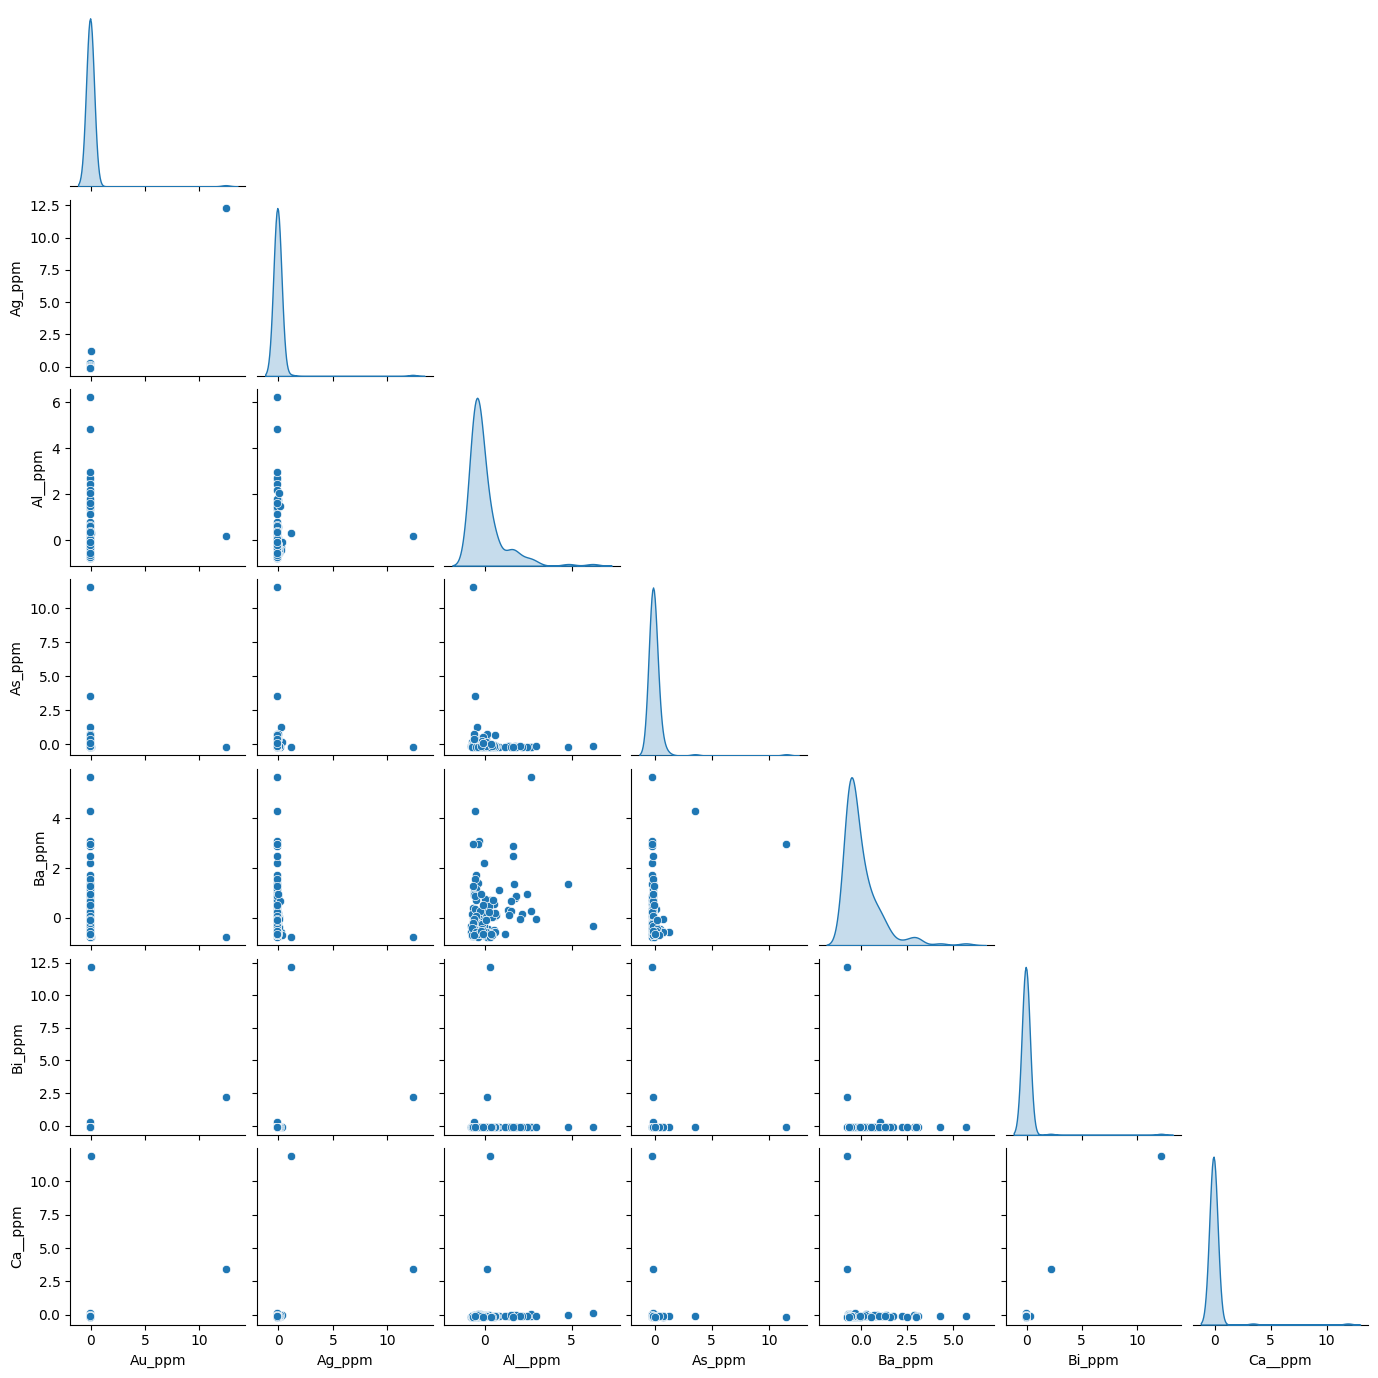

In [46]:
# Generate pairplot of select elements
elements_to_plot = [
    "Au_ppm",
    "Ag_ppm",
    "Al__ppm",
    "As_ppm",
    "Ba_ppm",
    "Bi_ppm",
    "Ca__ppm",
]  # Choose key elements - ideally those related to mineralization or other interesting trends
helper_functions.generate_pairplot(df, elements_to_plot, height=2)

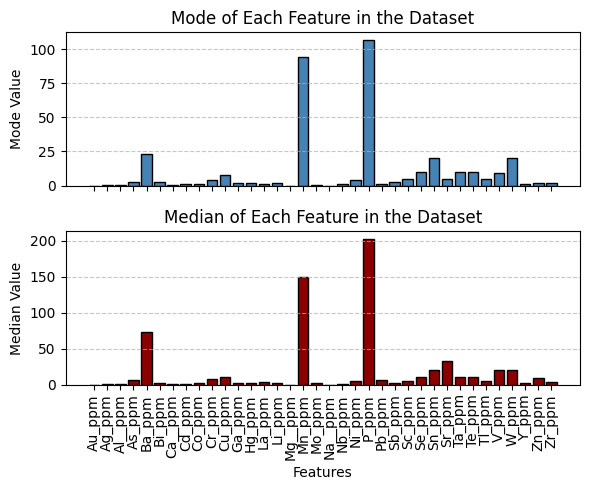

In [48]:
# Compute mode (first mode value) and median for each feature
helper_functions.plot_mode_median(df, feature_columns)

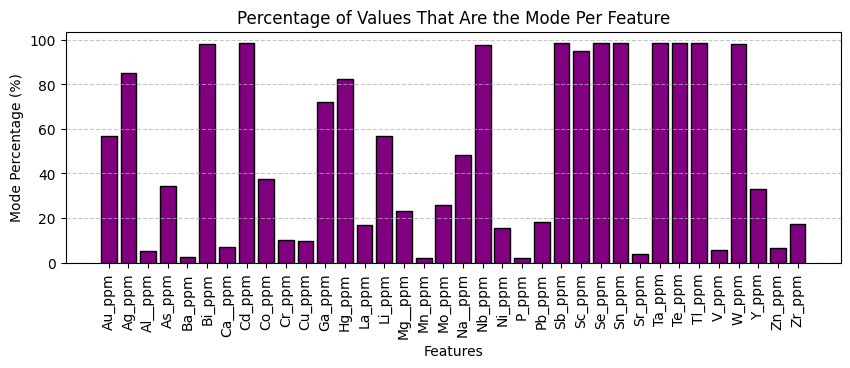

In [49]:
# Count number of modes per column
helper_functions.plot_mode_percentage(df, feature_columns)

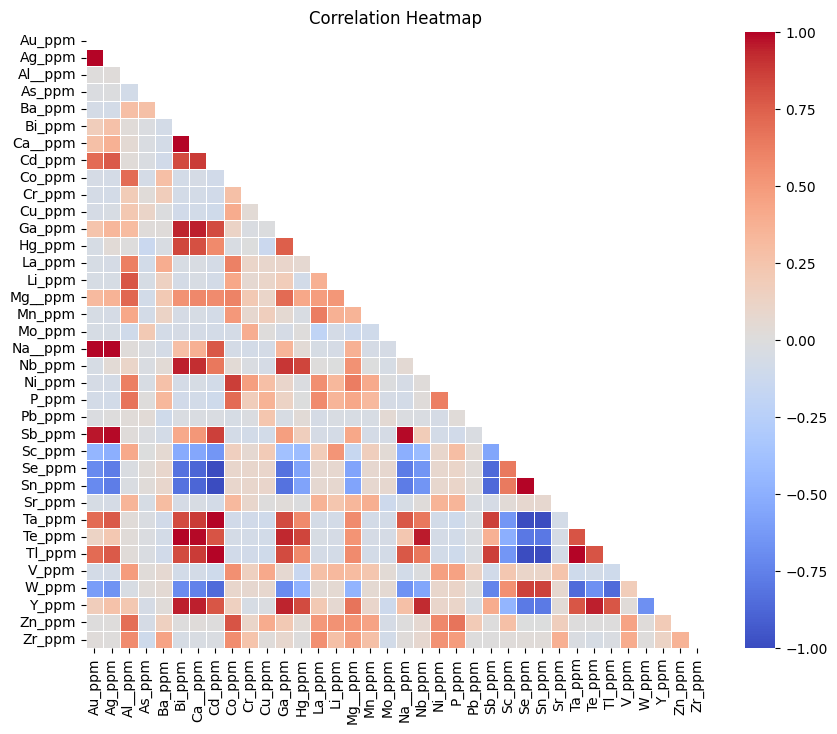

In [50]:
# Generate correlation heatmap
helper_functions.plot_correlation_heatmap(
    df, feature_columns, figsize=(10, 8), annot=False
)  # Increase figsize to view all element labels

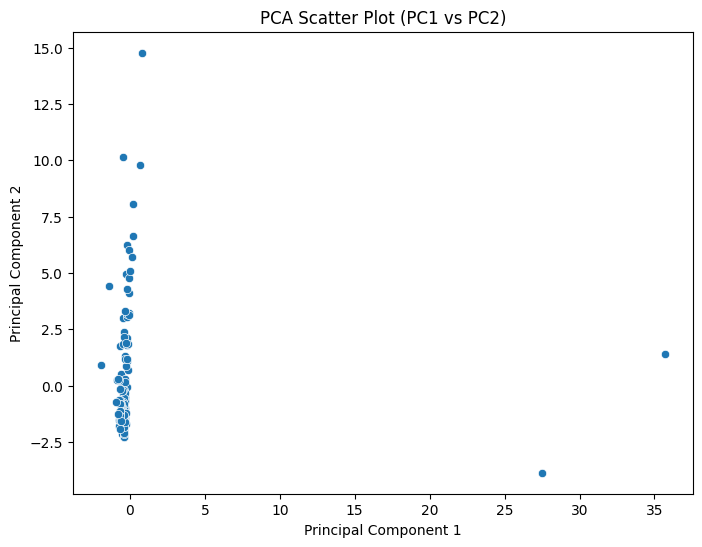

Top 5 Contributing Features to PC1: ['Ta_ppm', 'Tl_ppm', 'Cd_ppm', 'Se_ppm', 'Sn_ppm']
Top 5 Contributing Features to PC2: ['Co_ppm', 'Al__ppm', 'Ni_ppm', 'Zn_ppm', 'P_ppm']


In [51]:
# PCA
pc1_scores, top_features1, top_features2 = helper_functions.generate_pca(
    df, feature_columns
)
print("Top 5 Contributing Features to PC1:", top_features1)
print("Top 5 Contributing Features to PC2:", top_features2)

---

## <u>Outlier Detection Methods</u>

Outliers in the binary plots below are classified using the Modified Z-Score method based on the Median Absolute Deviation (MAD). Data points with a modified Z-score greater than 3.5 are labeled as outliers (-1). This is done in place of the standard Contamination value, as it is hard to manually estimate the proportion of outliers in the datset. To modify the Z-score threshold, edit its default value at the top of the outlier_detection_functions.py file.

### <u>Isolation Forest</u>

Isolation forest is an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [52]:
IF_df = outlier_detection_functions.isolation_forest(df, feature_columns)

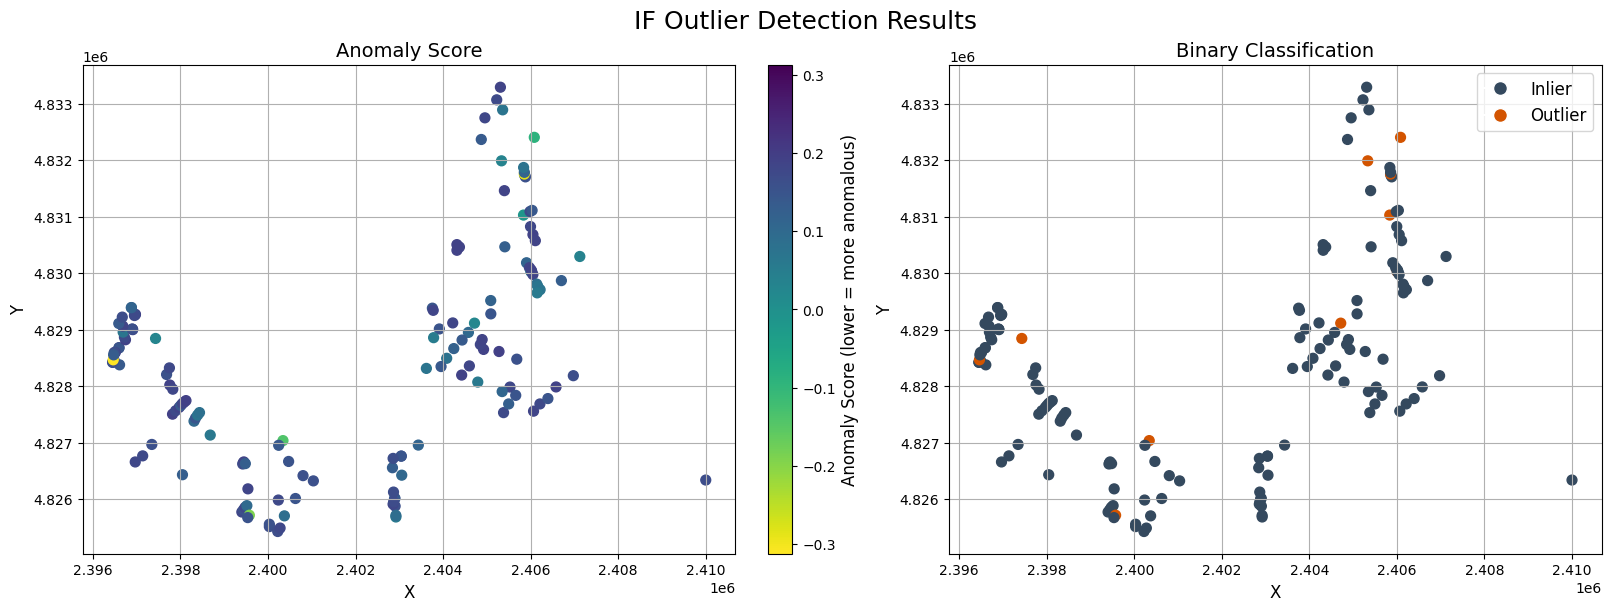

Classified 10 outliers out of 155 samples


In [53]:
# Plotting IF results
helper_functions.plot_outlier_results(
    data=IF_df,
    x_col="X",
    y_col="Y",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
    cmap="viridis_r",
)


---

### <u>Local Outlier Factor</u>

LOF is another unsupervised outlier detection method that uses a density-based approach, comparing the density of data points in their local neighborhoods. Isolated samples or those on the margins of a neighborhood cluster will have a lower density than their neighbors. Samples with a lower LOF value are considered outliers. Similar to IF, LOF is unaffected by data distribution but does require some parameter-tuning.

In [54]:
LOF_df = outlier_detection_functions.local_outlier_factor(
    df, feature_columns, n_neighbors=50, scale_data=False
)

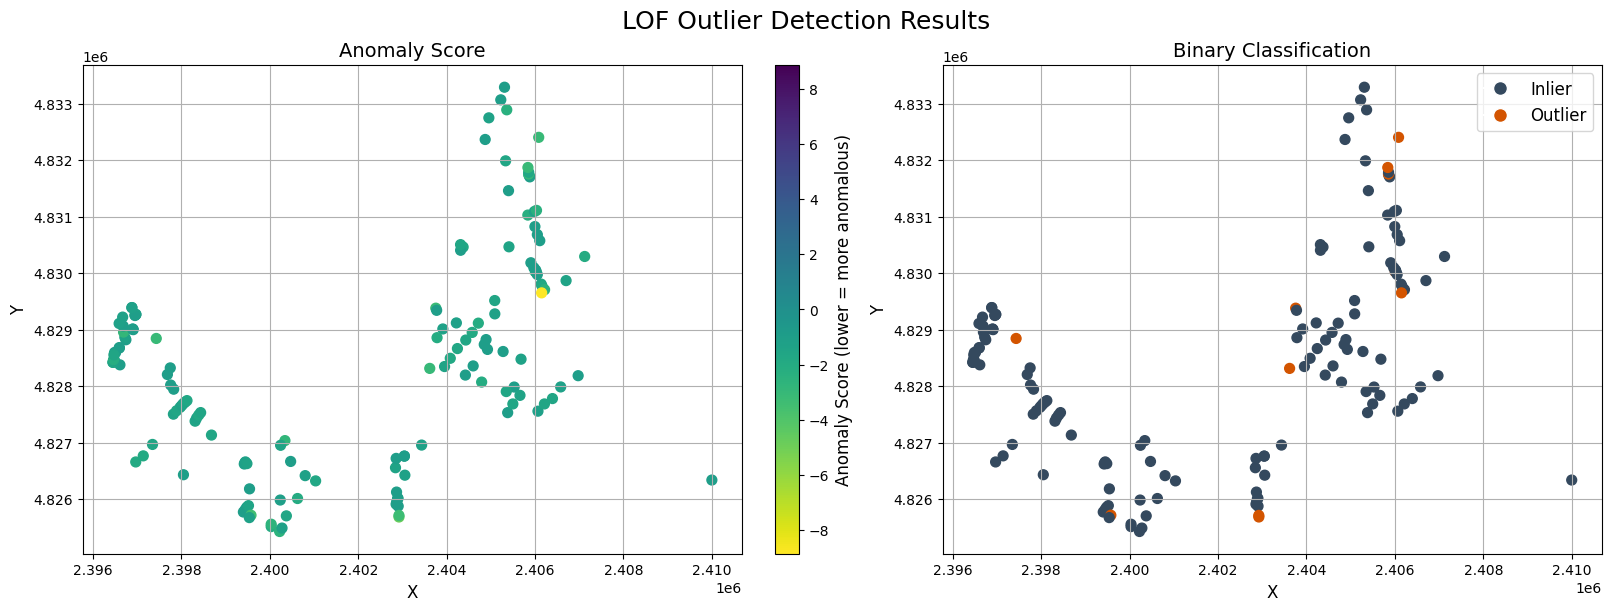

Classified 11 outliers out of 155 samples


In [55]:
# Plotting LOF results
helper_functions.plot_outlier_results(
    data=LOF_df,
    x_col="X",
    y_col="Y",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="LOF Outlier Detection Results",
    cmap="viridis_r",
)


---

### <u>Angle Based Outlier Detection</u>

Our final method of outlier detection is angle based outlier detection. This method compares the distribution of angles of distance vectors between a sample point and its neighbors; a point with a large distribution of vector angles is considered an inlier (within a cluster), while a point with a smaller distribution of angles is likely an outlier (outside a cluster). An angle-based score is then calculated, with less variation indicating a higher probability of the sample point being an outlier. One benefit of ABOD is that it is free of any parameters, and thus does not have the potential prediction variability resulting from tuning. Its implementation does not, however, output a binary classification, thus in order to generate one an arbitrary threshold must be defined. 

In [56]:
ABOD_df = outlier_detection_functions.abod(
    df, feature_columns, scale_data=True, use_knn=True, k_neighbors=100
)

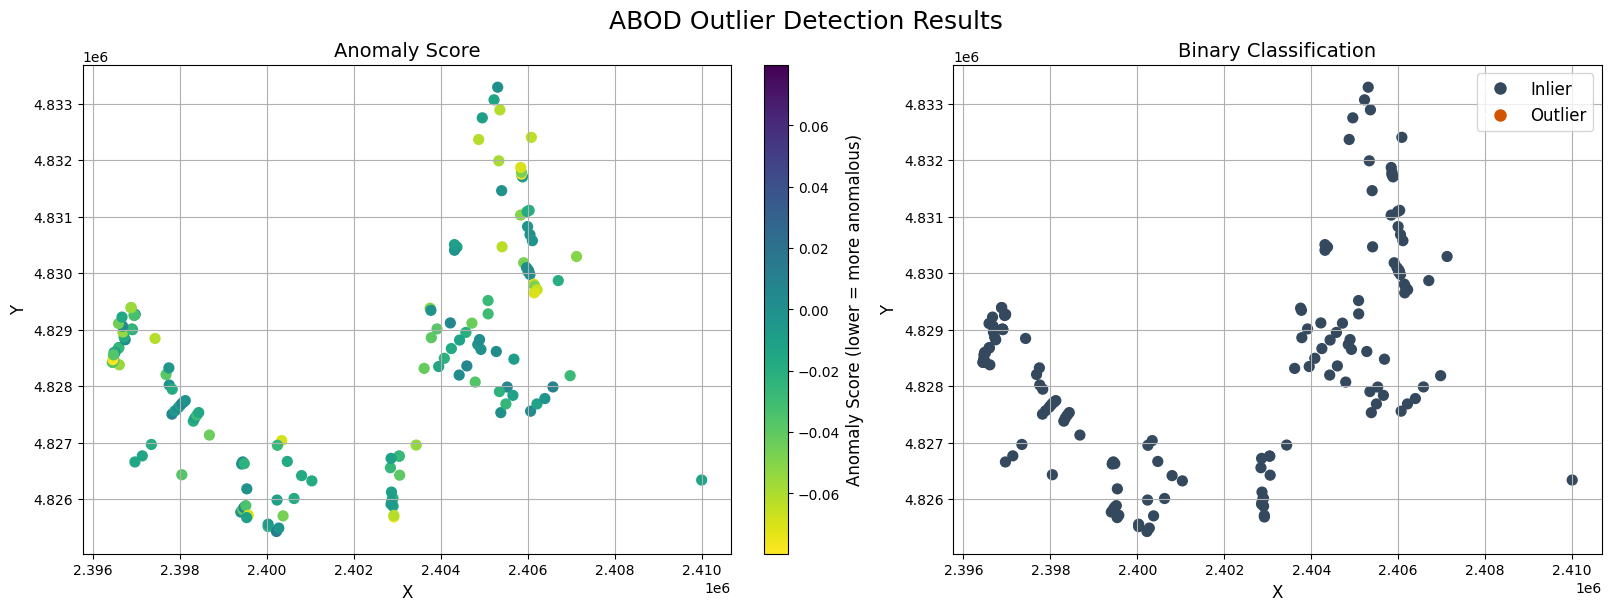

Classified 0 outliers out of 155 samples


In [57]:
# Plotting ABOD results
helper_functions.plot_outlier_results(
    data=ABOD_df,
    x_col="X",
    y_col="Y",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="ABOD Outlier Detection Results",
    cmap="viridis_r",
)

---

## <u>Validation of predictions</u>

Multivariate anomaly detection picks up on trends across multiple elements, rather than just single-element variation. As opposed to univariate anomalies that may be attributed to noise, sampling error, or highly-localized trends, multivariate analysis may point towards regions of broader geologic alteration related to mineral deposits. To test this relationship, we will compare outlier predictions from each model against known mineral occurrences in the sampling region. 

In [ ]:
# raw_df = pd.read_parquet("data_files/AK_raw_data.parquet")
# validation_df = pd.read_parquet("data_files/AK_validation.parquet")

# print(raw_df.columns)
# print(validation_df.columns)

validation_df = pd.read_csv("data_files/Compositado_au_ag_1m.csv")
validation_df.rename(columns={"mid_x": "X", "mid_y": "Y", "mid_z": "Z"}, inplace=True)

validation_df_ag = validation_df[validation_df["Ag_ppm"] >= 25]  # CHANGE TO desired cut
validation_df_au = validation_df[
    validation_df["Au_ppm"] >= 0.5
]  # CHANGE TO desired cut


validation_df_ag.shape, validation_df_au.shape

((11135, 8), (9976, 8))

### *Spatial validation of outlier predictions*

To start, we will conduct a visual analysis on the data, comparing binary outlier classifications vs. known mineral occurrences in the region.

#### Gold data

Points detected as outliers by 1 model: 11
Points detected as outliers by 2 models: 5
Points detected as outliers by all 3 models: 0


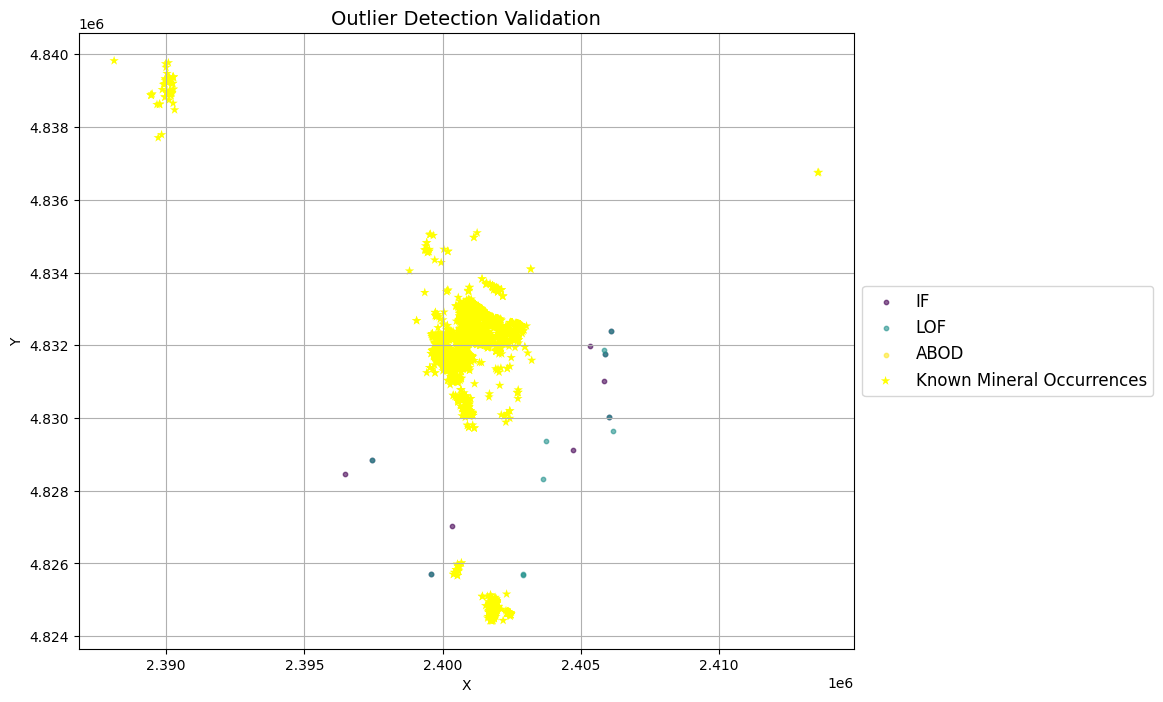

In [59]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ["IF", "LOF", "ABOD"]

helper_functions.plot_validation(
    outlier_datasets=outlier_results,
    outlier_dataset_names=outlier_result_names,
    validation_df=validation_df_au,
    point_size=10,
    colormap="viridis",
    x_col="X",
    y_col="Y",
)

#### Silver Data

Points detected as outliers by 1 model: 11
Points detected as outliers by 2 models: 5
Points detected as outliers by all 3 models: 0


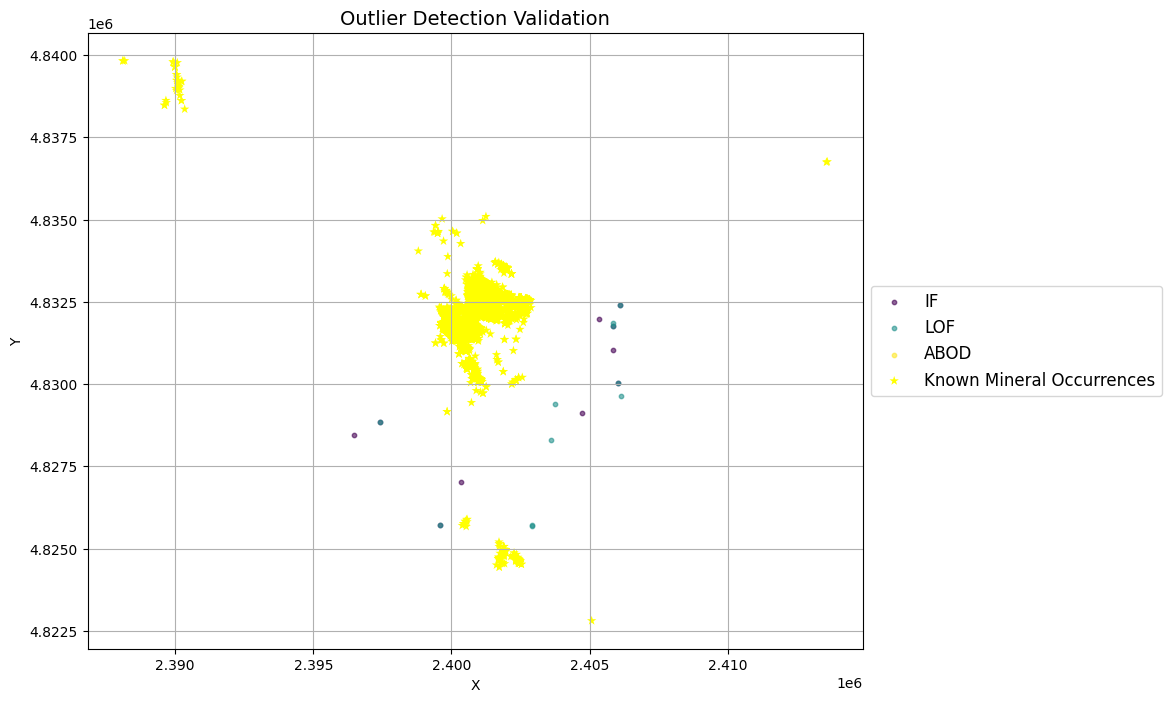

In [60]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ["IF", "LOF", "ABOD"]

helper_functions.plot_validation(
    outlier_datasets=outlier_results,
    outlier_dataset_names=outlier_result_names,
    validation_df=validation_df_ag,
    point_size=10,
    colormap="viridis",
    x_col="X",
    y_col="Y",
)

---

### *ROC-AUC, ANOVA F-statistic, and Mutual Information scoring of outlier predictions*

To quantitatively compare the different outlier prediction methods, we will use three different scoring methods: ROC-AUC, ANOVA F-statistic, and Mutual Information.
<br />
<br />
- *<u>ROC-AUC, or Receiver Operating Characteristic Area Under the Curve</u>* is a machine learning metric used to evaluate a model's ability to distinguish between positive and negative classes; a score of 1 is considered 'perfect,' or that the model gets 100% of predictions correct. 
    - Generally best for evaluating overall predictive performance, regardless of spatial location.
<br />
<br />
- The *<u>ANOVA F-statistic</u>* is a method of comparing the variances of two samples (in this case the prediction and the validation set); the higher the score, the greater the model's predictions are differentiated. That is, there is a meaningful pattern between predicted outliers and known mineral deposits.
    - Measures how well the model distinguishes spatially relevant anomalies.
<br />
<br />
- *<u>Mutual Information</u>* is a method of measuring how much information one variable provides about another, or how dependent they are on each other. Higher MI values indicate stronger relationships between variables. 
    - Quantifies dependency between outlier predictions and proximity to known deposits.


*Note: due to the large sample size of the dataset and the way that F- and MI scores are calculated, the results from these two are skewed.*

ROC-AUC Score for IF: 0.4645
ROC-AUC Score for LOF: 0.5132
ROC-AUC Score for ABOD: 0.5016
F-Score for IF: 0.2618
F-Score for LOF: 0.5466
F-Score for ABOD: 0.0100
Mutual Information Score for IF: 0.0019
Mutual Information Score for LOF: 0.0097
Mutual Information Score for ABOD: 0.0000


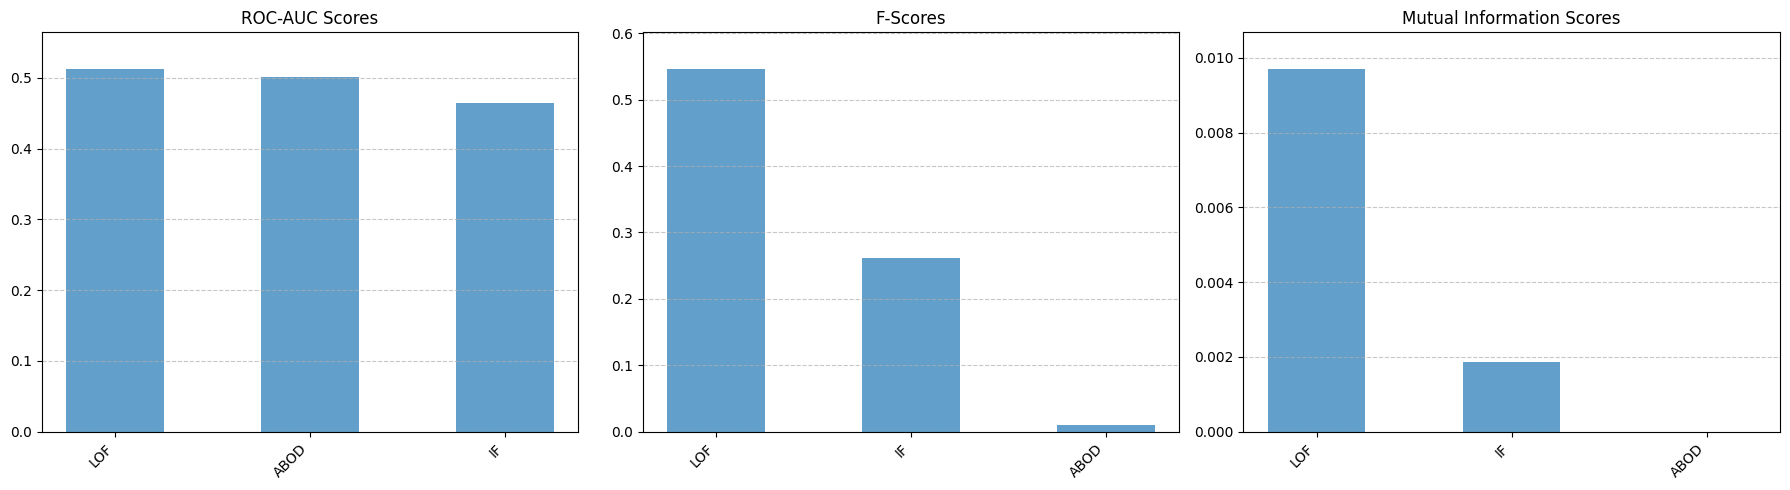

In [61]:
# Calculate scores for each outlier detection method

scoring_radius = 200  # Radius in meters to calculate scores

roc_auc_scores = helper_functions.calculate_roc_auc(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="X",
    y_col="Y",
)

f_scores = helper_functions.calculate_f_score(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="X",
    y_col="Y",
)

mi_scores = helper_functions.calculate_mi_score(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="X",
    y_col="Y",
)

helper_functions.plot_scores(
    [roc_auc_scores, f_scores, mi_scores],
    titles=["ROC-AUC Scores", "F-Scores", "Mutual Information Scores"],
)

---

### *Deeper investigation into ROC-AUC scoring of each model*

Lets create a ROC curve for each model to better understand the way that they are performing compared to each other. 

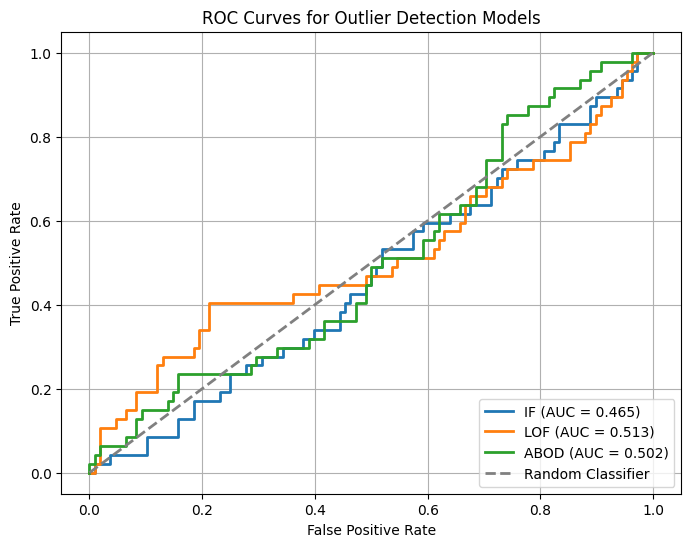

In [62]:
helper_functions.plot_roc_curves(
    outlier_datasets=outlier_results,  # Your outlier model DataFrames
    outlier_dataset_names=outlier_result_names,  # Names of models
    validation_df=validation_df,  # Known mineral deposits
    radius=scoring_radius,
    x_col="X",
    y_col="Y",
)

The ROC curve above generally matches the results we observed in the first peek into model performance - IF best optimizes the TPR/FPR ratio, closely followed by LOF. ABOD actually skews towards the false positive side of the graph. This may be due to the fact that we are utilizing k-nearest neighbors to optimize its processing time. Unfortunately, at least on the system this code was created on, to process the full dataset would take approx. 250 hours, which is not feasible for this analysis. Further investigation into the effects of kNN on model accuracy is needed. 

---

### <u>Time Cost Analysis</u>

Given the significant time-cost differences between models, it is important to consider how they compare relative to model accuracy; IF and LOF process almost instantly, while ABOD takes some time due to the nature of the calculation. For relatively small datasets, the time cost of ABOD is minimal, but for larger datasets the tradeoffs should be considered; it may be more efficient to use an algorithm like Isolation Forest.

Below we will do a brief investigation into the time cost of each method, focusing particularly on ABOD.

In [63]:
outlier_models = [
    outlier_detection_functions.isolation_forest,
    outlier_detection_functions.local_outlier_factor,
    lambda df, feature_columns: outlier_detection_functions.abod(
        df, feature_columns, use_knn=True, k_neighbors=50
    ),
]

outlier_model_names = ["IF", "LOF", "ABOD"]
scoring_radius = 200

# Dictionary to store results
results = {"Model": [], "Iteration": [], "Execution Time (s)": [], "ROC-AUC Score": []}

for model, name in zip(outlier_models, outlier_model_names):
    for i in range(7):
        start = time.time()
        output_df = model(df, feature_columns)  # abod will be called with use_knn=True
        end = time.time()
        exec_time = end - start

        print(f"{name} iteration {i} took {exec_time} seconds")

        roc_auc_score = helper_functions.calculate_roc_auc(
            outlier_datasets=[output_df],
            outlier_dataset_names=[name],
            validation_df=validation_df,
            radius=scoring_radius,
            x_col="X",
            y_col="Y",
        )[name]

        # Store results in dictionary
        results["Model"].append(name)
        results["Iteration"].append(i)
        results["Execution Time (s)"].append(exec_time)
        results["ROC-AUC Score"].append(roc_auc_score)

IF iteration 0 took 0.08260393142700195 seconds
ROC-AUC Score for IF: 0.4645
IF iteration 1 took 0.06157088279724121 seconds
ROC-AUC Score for IF: 0.4645
IF iteration 2 took 0.061145782470703125 seconds
ROC-AUC Score for IF: 0.4645
IF iteration 3 took 0.05611610412597656 seconds
ROC-AUC Score for IF: 0.4645
IF iteration 4 took 0.06574225425720215 seconds
ROC-AUC Score for IF: 0.4645
IF iteration 5 took 0.057717084884643555 seconds
ROC-AUC Score for IF: 0.4645
IF iteration 6 took 0.06267309188842773 seconds
ROC-AUC Score for IF: 0.4645
LOF iteration 0 took 0.005621194839477539 seconds
ROC-AUC Score for LOF: 0.5453
LOF iteration 1 took 0.004174709320068359 seconds
ROC-AUC Score for LOF: 0.5453
LOF iteration 2 took 0.003786802291870117 seconds
ROC-AUC Score for LOF: 0.5453
LOF iteration 3 took 0.00403594970703125 seconds
ROC-AUC Score for LOF: 0.5453
LOF iteration 4 took 0.004096031188964844 seconds
ROC-AUC Score for LOF: 0.5453
LOF iteration 5 took 0.004467010498046875 seconds
ROC-AUC Sc

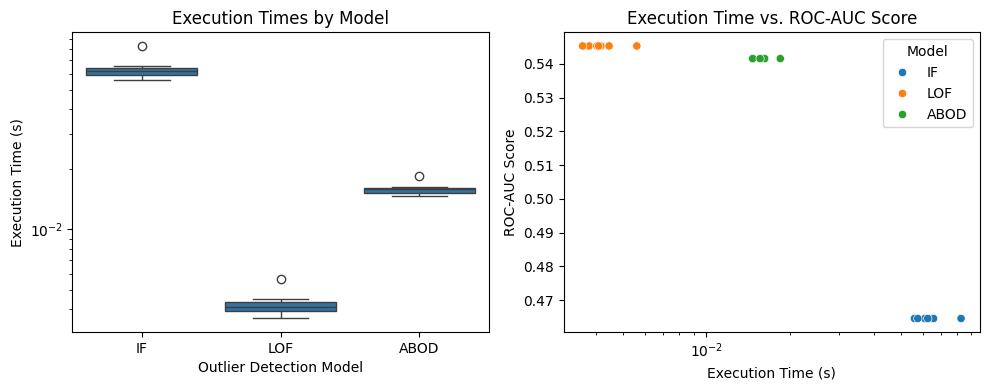

In [64]:
# Plot the results of the above analysis

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Box Plot
sns.boxplot(x="Model", y="Execution Time (s)", data=results_df, ax=axes[0])
axes[0].set_title("Execution Times by Model")
axes[0].set_xlabel("Outlier Detection Model")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_yscale("log")

# Scatter Plot
sns.scatterplot(
    x="Execution Time (s)", y="ROC-AUC Score", hue="Model", data=results_df, ax=axes[1]
)
axes[1].set_title("Execution Time vs. ROC-AUC Score")
axes[1].set_xlabel("Execution Time (s)")
axes[1].set_xscale("log")
axes[1].set_ylabel("ROC-AUC Score")
axes[1].legend(title="Model")

plt.tight_layout()
plt.show()

As we can see in the above plots, IF has both a lower execution time as well as higher ROC-AUC score than LOF, which is then significantly faster and more accurate than ABOD. Given this, it does not seem practical to utilize LOF or ABOD, at least in the context of the given dataset. It is important to note that the ABOD function run in this analysis utilizes kNN downsampling to speed up processing times, which may have an impact on model accuracy.

In [65]:
# Analyze the execution time of each method with varying sample sizes

# Define sample sizes
# sample_sizes = [50, 100, 200, 400, 800] #Change based on the df size
sample_sizes = [10, 25, 50, 100, 150]

# Measure execution time
abod_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.abod
)

if_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.isolation_forest
)

lof_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.local_outlier_factor
)


Processed 10 samples in 0.0840 seconds using abod
Processed 25 samples in 0.0092 seconds using abod
Processed 50 samples in 0.0173 seconds using abod
Processed 100 samples in 0.0176 seconds using abod
Processed 150 samples in 0.0279 seconds using abod
Processed 10 samples in 0.0628 seconds using isolation_forest
Processed 25 samples in 0.0641 seconds using isolation_forest
Processed 50 samples in 0.0672 seconds using isolation_forest
Processed 100 samples in 0.0670 seconds using isolation_forest
Processed 150 samples in 0.0665 seconds using isolation_forest
Processed 10 samples in 0.0050 seconds using local_outlier_factor
Processed 25 samples in 0.0054 seconds using local_outlier_factor
Processed 50 samples in 0.0051 seconds using local_outlier_factor
Processed 100 samples in 0.0043 seconds using local_outlier_factor
Processed 150 samples in 0.0048 seconds using local_outlier_factor


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


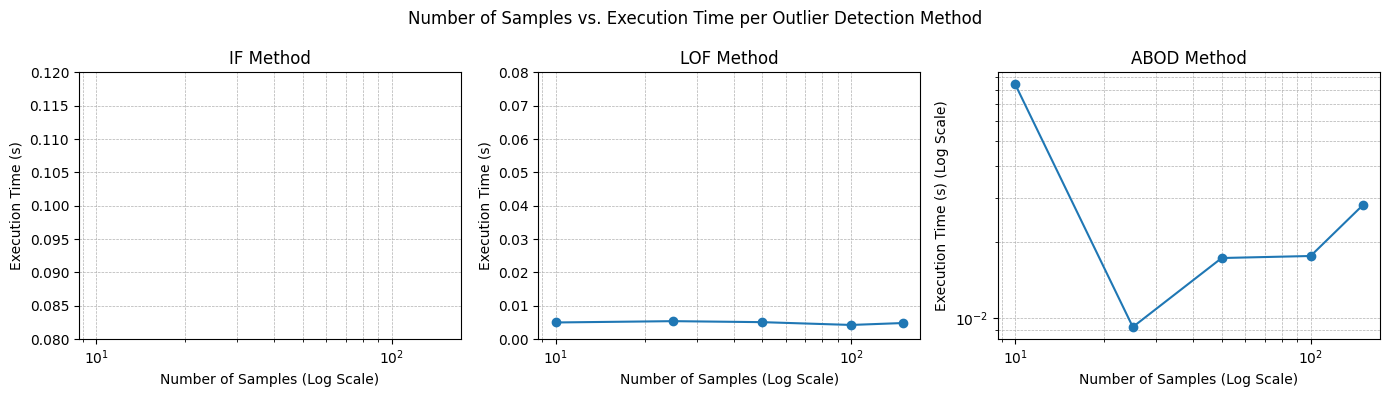

In [66]:
# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# IF
axes[0].plot(
    if_results_df["Number of Samples"],
    if_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[0].set_xlabel("Number of Samples (Log Scale)")
axes[0].set_xscale("log")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_ylim(0.08, 0.12)
axes[0].set_title("IF Method")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# LOF
axes[1].plot(
    lof_results_df["Number of Samples"],
    lof_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[1].set_xlabel("Number of Samples (Log Scale)")
axes[1].set_xscale("log")
axes[1].set_ylabel("Execution Time (s)")
axes[1].set_ylim(0, 0.08)
axes[1].set_title("LOF Method")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

## ABOD
axes[2].plot(
    abod_results_df["Number of Samples"],
    abod_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Number of Samples (Log Scale)")
axes[2].set_ylabel("Execution Time (s) (Log Scale)")
axes[2].set_title("ABOD Method")
axes[2].grid(True, which="both", linestyle="--", linewidth=0.5)

fig.suptitle("Number of Samples vs. Execution Time per Outlier Detection Method")
plt.tight_layout()
plt.show()

As we can see above, ABOD has more similar execution times as IF/LOF (<1s) when n<~200, but beyond that the time cost grows exponentially. IF and LOF distributions are irregular due to the extremely short processing times, and variation can be attributed to random noise; they generally follow an O(n) time complexity, while ABOD appears to follow O(n^2), which aligns with the pairwise computations required to calculate ABOD. 

To summarize, for the purpose of analyzing this dataset (or any large dataset n>~10000), IF is the clear choice to best balance processing time and model accuracy. 